In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Sun Dec 15 16:00:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              12W /  7

In [8]:
%%writefile histogram.cu
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <random>
#include <cuda_runtime.h>
#include <fstream>  // For file output
#define NUM_BINS 4096
#define BIN_MAX 127

__global__ void histogram_kernel(unsigned int *input, unsigned int *bins,
                                 unsigned int num_elements,
                                 unsigned int num_bins) {
    // Use shared memory for the histogram bins
    extern __shared__ unsigned int shared_bins[];

    // Initialize shared memory bins to zero
    int tid = threadIdx.x;
    for (int i = tid; i < num_bins; i += blockDim.x) {
        shared_bins[i] = 0;
    }
    __syncthreads();

    // Compute the histogram using shared memory and atomics
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    while (idx < num_elements) {
        atomicAdd(&shared_bins[input[idx]], 1);
        idx += stride;
     }

    __syncthreads();

    // Merge shared memory bins into global memory bins using atomics
    for (int i = tid; i < num_bins; i += blockDim.x) {
        atomicAdd(&bins[i], shared_bins[i]);
    }
}

__global__ void convert_kernel(unsigned int *bins, unsigned int num_bins) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    while (idx < num_bins) {
        if (bins[idx] > BIN_MAX) {
            bins[idx] = BIN_MAX;
        }
        idx += stride;
    }
}

int main(int argc, char **argv) {
    if (argc != 2) {
        printf("Usage: %s <inputLength>\n", argv[0]);
        return 1;
    }

    int inputLength = atoi(argv[1]);
    printf("The input length is %d\n", inputLength);

    unsigned int *hostInput, *hostBins, *resultRef;
    unsigned int *deviceInput, *deviceBins;

    // Allocate Host memory for input and output
    hostInput = (unsigned int *)malloc(inputLength * sizeof(unsigned int));
    hostBins = (unsigned int *)malloc(NUM_BINS * sizeof(unsigned int));
    resultRef = (unsigned int *)malloc(NUM_BINS * sizeof(unsigned int));

    // Initialize hostInput to random numbers whose values range from 0 to (NUM_BINS - 1)
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_int_distribution<> dis(0, NUM_BINS - 1);
    for (int i = 0; i < inputLength; ++i) {
        hostInput[i] = dis(gen);
    }

    // Create reference result in CPU
    for (int i = 0; i < NUM_BINS; ++i) {
        resultRef[i] = 0;
    }
    for (int i = 0; i < inputLength; ++i) {
        if (resultRef[hostInput[i]] < BIN_MAX) {
            resultRef[hostInput[i]]++;
        }
    }

    // Allocate GPU memory
    cudaMalloc(&deviceInput, inputLength * sizeof(unsigned int));
    cudaMalloc(&deviceBins, NUM_BINS * sizeof(unsigned int));

    // Copy memory to the GPU
    cudaMemcpy(deviceInput, hostInput, inputLength * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemset(deviceBins, 0, NUM_BINS * sizeof(unsigned int));

    // Initialize grid and block dimensions
    int threadsPerBlock = 256;
    int blocksPerGrid = (inputLength + threadsPerBlock - 1) / threadsPerBlock;

    // Launch the histogram kernel
    size_t sharedMemSize = NUM_BINS * sizeof(unsigned int);
    histogram_kernel<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(deviceInput, deviceBins, inputLength, NUM_BINS);

    // Launch the cleanup kernel
    blocksPerGrid = (NUM_BINS + threadsPerBlock - 1) / threadsPerBlock;
    convert_kernel<<<blocksPerGrid, threadsPerBlock>>>(deviceBins, NUM_BINS);

    // Copy the GPU memory back to the CPU
    cudaMemcpy(hostBins, deviceBins, NUM_BINS * sizeof(unsigned int), cudaMemcpyDeviceToHost);

    // Compare the output with the reference
    bool match = true;
    for (int i = 0; i < NUM_BINS; ++i) {
        if (hostBins[i] != resultRef[i]) {
            printf("Mismatch at bin %d: GPU %d, CPU %d\n", i, hostBins[i], resultRef[i]);
            match = false;
            break;
        }
    }

    if (match) {
        printf("Results match!\n");
    } else {
        printf("Results do not match!\n");
    }


    // Save hostBins to a file
    printf("Saving histogram...\n");
    std::ofstream outfile("histogram_data.txt");
    for (int i = 0; i < NUM_BINS; ++i) {
        outfile << hostBins[i] << std::endl;
    }
    outfile.close();

    // Free the GPU memory
    cudaFree(deviceInput);
    cudaFree(deviceBins);

    // Free the CPU memory
    free(hostInput);
    free(hostBins);
    free(resultRef);

    return 0;
}


Overwriting histogram.cu


In [9]:
!nvcc histogram.cu -o histogram_exec
!./histogram_exec 1024

The input length is 1024
Results match!


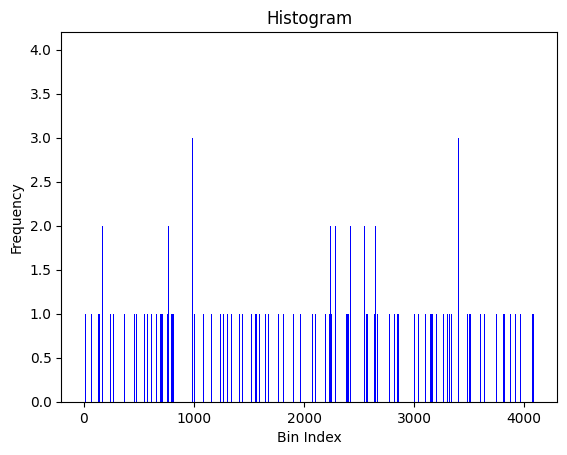

In [10]:
# /content/histogram_data.txt
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read histogram data from the uploaded file
data = np.loadtxt("histogram_data.txt", dtype=int)

# Step 2: Define bins and plot the histogram
bins = np.arange(len(data))
plt.bar(bins, data, color='blue')

# Step 3: Customize and display the plot
plt.title("Histogram")
plt.xlabel("Bin Index")
plt.ylabel("Frequency")
plt.show()

In [11]:
%%writefile histogram_nsight.cu
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <random>
#include <cuda_runtime.h>

#define NUM_BINS 4096
#define BIN_MAX 127

__global__ void histogram_kernel(unsigned int *input, unsigned int *bins,
                                 unsigned int num_elements,
                                 unsigned int num_bins) {
    // Use shared memory for the histogram bins
    extern __shared__ unsigned int shared_bins[];

    // Initialize shared memory bins to zero
    int tid = threadIdx.x;
    for (int i = tid; i < num_bins; i += blockDim.x) {
        shared_bins[i] = 0;
    }
    __syncthreads();

    // Compute the histogram using shared memory and atomics
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    while (idx < num_elements) {
        atomicAdd(&shared_bins[input[idx]], 1);
        idx += stride;
     }

    __syncthreads();

    // Merge shared memory bins into global memory bins using atomics
    for (int i = tid; i < num_bins; i += blockDim.x) {
        atomicAdd(&bins[i], shared_bins[i]);
    }
}

__global__ void convert_kernel(unsigned int *bins, unsigned int num_bins) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int stride = blockDim.x * gridDim.x;

    while (idx < num_bins) {
        if (bins[idx] > BIN_MAX) {
            bins[idx] = BIN_MAX;
        }
        idx += stride;
    }
}

int main(int argc, char **argv) {
    int inputLength = 1024000;
    printf("The input length is %d\n", inputLength);

    unsigned int *hostInput, *hostBins, *resultRef;
    unsigned int *deviceInput, *deviceBins;

    // Allocate Host memory for input and output
    hostInput = (unsigned int *)malloc(inputLength * sizeof(unsigned int));
    hostBins = (unsigned int *)malloc(NUM_BINS * sizeof(unsigned int));
    resultRef = (unsigned int *)malloc(NUM_BINS * sizeof(unsigned int));

    // Initialize hostInput to random numbers whose values range from 0 to (NUM_BINS - 1)
    std::random_device rd;
    std::mt19937 gen(rd());
    std::uniform_int_distribution<> dis(0, NUM_BINS - 1);
    for (int i = 0; i < inputLength; ++i) {
        hostInput[i] = dis(gen);
    }

    // Create reference result in CPU
    for (int i = 0; i < NUM_BINS; ++i) {
        resultRef[i] = 0;
    }
    for (int i = 0; i < inputLength; ++i) {
        if (resultRef[hostInput[i]] < BIN_MAX) {
            resultRef[hostInput[i]]++;
        }
    }

    // Allocate GPU memory
    cudaMalloc(&deviceInput, inputLength * sizeof(unsigned int));
    cudaMalloc(&deviceBins, NUM_BINS * sizeof(unsigned int));

    // Copy memory to the GPU
    cudaMemcpy(deviceInput, hostInput, inputLength * sizeof(unsigned int), cudaMemcpyHostToDevice);
    cudaMemset(deviceBins, 0, NUM_BINS * sizeof(unsigned int));

    // Initialize grid and block dimensions
    int threadsPerBlock = 256;
    int blocksPerGrid = (inputLength + threadsPerBlock - 1) / threadsPerBlock;

    // Launch the histogram kernel
    size_t sharedMemSize = NUM_BINS * sizeof(unsigned int);
    histogram_kernel<<<blocksPerGrid, threadsPerBlock, sharedMemSize>>>(deviceInput, deviceBins, inputLength, NUM_BINS);

    // Launch the cleanup kernel
    blocksPerGrid = (NUM_BINS + threadsPerBlock - 1) / threadsPerBlock;
    convert_kernel<<<blocksPerGrid, threadsPerBlock>>>(deviceBins, NUM_BINS);

    // Copy the GPU memory back to the CPU
    cudaMemcpy(hostBins, deviceBins, NUM_BINS * sizeof(unsigned int), cudaMemcpyDeviceToHost);

    // Compare the output with the reference
    bool match = true;
    for (int i = 0; i < NUM_BINS; ++i) {
        if (hostBins[i] != resultRef[i]) {
            printf("Mismatch at bin %d: GPU %d, CPU %d\n", i, hostBins[i], resultRef[i]);
            match = false;
            break;
        }
    }

    if (match) {
        printf("Results match!\n");
    } else {
        printf("Results do not match!\n");
    }

    // Free the GPU memory
    cudaFree(deviceInput);
    cudaFree(deviceBins);

    // Free the CPU memory
    free(hostInput);
    free(hostBins);
    free(resultRef);

    return 0;
}

Overwriting histogram_nsight.cu


In [12]:
!nvcc histogram_nsight.cu -o histogram_exec_nsight
!ncu ./histogram_exec_nsight

The input length is 1024000
==PROF== Connected to process 8322 (/content/histogram_exec_nsight)
==PROF== Profiling "histogram_kernel" - 0: 0%....50%....100% - 8 passes
==PROF== Profiling "convert_kernel" - 1: 0%....50%....100% - 8 passes
Results match!
==PROF== Disconnected from process 8322
[8322] histogram_exec_nsight@127.0.0.1
  histogram_kernel(unsigned int *, unsigned int *, unsigned int, unsigned int) (4000, 1, 1)x(256, 1, 1), Context 1, Stream 7, Device 0, CC 7.5
    Section: GPU Speed Of Light Throughput
    ----------------------- ------------- ------------
    Metric Name               Metric Unit Metric Value
    ----------------------- ------------- ------------
    DRAM Frequency          cycle/nsecond         4.98
    SM Frequency            cycle/usecond       583.92
    Elapsed Cycles                  cycle      135,196
    Memory Throughput                   %        60.36
    DRAM Throughput                     %         7.46
    Duration                      usecond 